In [35]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')



In [36]:
# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
df['age'] = imputer.fit_transform(df['age'].values.reshape(-1, 1))
df['bmi'] = imputer.fit_transform(df['bmi'].values.reshape(-1, 1))
df['HbA1c_level'] = imputer.fit_transform(df['HbA1c_level'].values.reshape(-1, 1))

# Convert categorical variables to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
import numpy as np

# Drop unnecessary columns (if any)
df = df.drop(['gender_Male', 'gender_Other'], axis=1)

# Convert boolean columns to integer
bool_columns = ['smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']
df[bool_columns] = df[bool_columns].astype(int)

# Convert target variable to NumPy array of type float32
y = df['diabetes'].values.astype(np.float32)

# Drop the target variable from the DataFrame
X = df.drop(['diabetes'], axis=1)

# Reshape X into a 3D array
X = X.values.reshape((X.shape[0], X.shape[1]))

# Now X is ready for CNN input


In [37]:
# Standardize the data
scaler = StandardScaler()
df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])


# Apply PCA for noise reduction
pca = PCA(n_components=None)  # Use all available components
df_pca = pd.DataFrame(pca.fit_transform(X))

# Combine PCA components with other features
df_combined = pd.concat([df, df_pca], axis=1)




In [38]:
# Split the data into features and target
X = df_combined.drop(['diabetes'], axis=1)
y = df_combined['diabetes']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural Network (CNN)
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test.values))

nn_pred_prob = model.predict(X_test.values)
nn_pred = np.round(nn_pred_prob)


            age  hypertension  heart_disease       bmi  HbA1c_level  \
0      1.692704             0              1 -0.321056     1.001706   
1      0.538006             0              0 -0.000116     1.001706   
2     -0.616691             0              0 -0.000116     0.161108   
3     -0.261399             0              0 -0.583232    -0.492690   
4      1.515058             1              1 -1.081970    -0.679490   
...         ...           ...            ...       ...          ...   
99995  1.692704             0              0 -0.000116     0.628107   
99996 -1.771388             0              0 -1.499343     0.908306   
99997  1.070944             0              0  0.076729     0.161108   
99998 -0.794336             0              0  1.220361    -1.426688   
99999  0.671241             0              0 -0.736922     1.001706   

       blood_glucose_level  diabetes  smoking_history_current  \
0                 0.047704         0                        0   
1                

In [39]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)

# Support Vector Machine (SVM) Classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
svm_pred = svm_classifier.predict(X_test)

# K-Nearest Neighbors (KNN) Classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_pred = knn_classifier.predict(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)


# Evaluate classifiers
classifiers = [rf_pred, svm_pred, knn_pred, nn_pred.flatten()]
classifier_names = ['Random Forest', 'SVM', 'KNN', 'Neural Network']

for i, pred in enumerate(classifiers):
    acc = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)

    print(f"\nMetrics for {classifier_names[i]}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{confusion}")




Metrics for Random Forest:
Accuracy: 0.9695
Precision: 0.9303
Recall: 0.6950
F1 Score: 0.7956
Confusion Matrix:
[[18203    89]
 [  521  1187]]

Metrics for SVM:
Accuracy: 0.9611
Precision: 0.9957
Recall: 0.5474
F1 Score: 0.7065
Confusion Matrix:
[[18288     4]
 [  773   935]]

Metrics for KNN:
Accuracy: 0.9564
Precision: 0.9058
Recall: 0.5463
F1 Score: 0.6815
Confusion Matrix:
[[18195    97]
 [  775   933]]

Metrics for Neural Network:
Accuracy: 0.9708
Precision: 0.9787
Recall: 0.6733
F1 Score: 0.7978
Confusion Matrix:
[[18267    25]
 [  558  1150]]


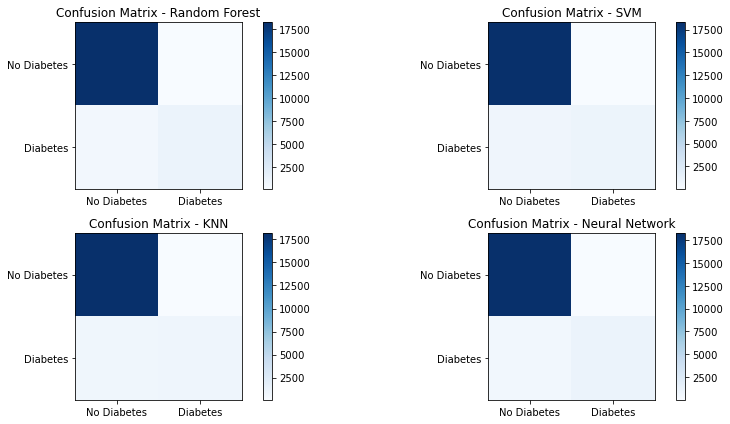

In [40]:
# Visualizations

plt.figure(figsize=(12, 6))

for i, pred in enumerate(classifiers):
    plt.subplot(2, 2, i+1)
    confusion = confusion_matrix(y_test, pred)
    plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {classifier_names[i]}')
    plt.colorbar()

    classes = ['No Diabetes', 'Diabetes']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

plt.tight_layout()
plt.show()
